In [22]:
import pandas as pd
import missingno as msno
import datetime
import calendar
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

In [23]:
all_data = pd.read_csv(".\\data\\processed_new\\all_data.csv")
all_data["Date"] = pd.to_datetime(all_data.Date)
all_data

,City,Date,CO_ow,NO2_ow,SO2_ow,PM2_5_ow,SO2_gov,CO_gov,NO2_gov,PM2_5_gov,PM2_5_sat,CO_sat,NO2_sat,SO2_sat,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential
0,Agartala,2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,521.116397,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Agra,2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,385.802356,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Aizwal,2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,151.677599,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Amritsar,2018-01-01,NaN,NaN,NaN,NaN,2.78,NaN,30.43,NaN,341.117255,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Asansol,2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,575.871380,NaN,32.193672,41.880880,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90905,Srinagar,2022-07-25,1544.873750,37.338750,12.002083,64.362917,15.10,250.0,10.17,16.98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
90906,Thiruvananthapuram,2022-07-25,234.206667,3.235000,2.802083,6.545833,NaN,NaN,NaN,NaN,NaN,NaN,9.377809,1.052403,22.0,52.0,33.0,30.0,28.0,20.0
90907,Varanasi,2022-07-25,718.474167,11.934583,7.788333,43.254167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,24.0,-5.0,57.0,18.0,18.0
90908,Vijaywada,2022-07-25,601.232500,12.245000,8.918750,27.298750,NaN,NaN,NaN,NaN,NaN,NaN,16.520525,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
city_list = all_data["City"].unique()

In [25]:
all_data.isna().sum()/len(all_data.index)

City                     0.000000
Date                     0.000000
CO_ow                    0.631559
NO2_ow                   0.631559
SO2_ow                   0.631559
PM2_5_ow                 0.631559
SO2_gov                  0.727555
CO_gov                   0.937873
NO2_gov                  0.726719
PM2_5_gov                0.752524
PM2_5_sat                0.971312
CO_sat                   0.801386
NO2_sat                  0.491156
SO2_sat                  0.773413
retail_and_recreation    0.608019
grocery_and_pharmacy     0.609460
parks                    0.608074
transit_stations         0.607799
workplaces               0.607524
residential              0.607524
dtype: float64

In [26]:
ow_start_date = min(all_data.dropna(subset="CO_ow")["Date"])
ow_end_date = max(all_data.dropna(subset="CO_ow")["Date"])

all_data_ow_dates = all_data[(all_data["Date"] >= ow_start_date) & (all_data["Date"] <= ow_end_date)]
all_data_ow_dates.isna().sum()/len(all_data_ow_dates.index)

City                     0.000000
Date                     0.000000
CO_ow                    0.000000
NO2_ow                   0.000000
SO2_ow                   0.000000
PM2_5_ow                 0.000000
SO2_gov                  0.636005
CO_gov                   0.908076
NO2_gov                  0.638155
PM2_5_gov                0.672339
PM2_5_sat                0.978833
CO_sat                   0.807971
NO2_sat                  0.490133
SO2_sat                  0.763189
retail_and_recreation    0.272727
grocery_and_pharmacy     0.275325
parks                    0.272727
transit_stations         0.272727
workplaces               0.272727
residential              0.272727
dtype: float64

<AxesSubplot:>

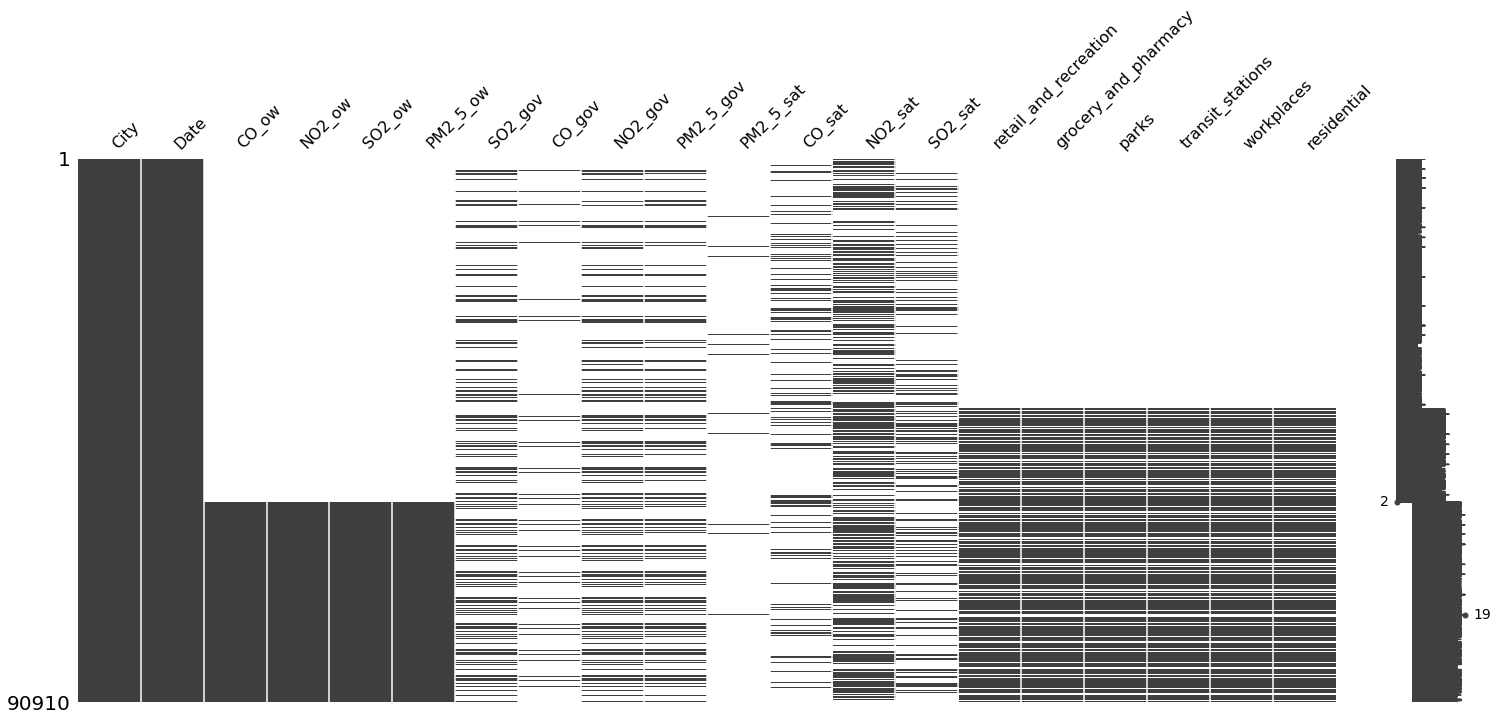

In [27]:
msno.matrix(all_data)

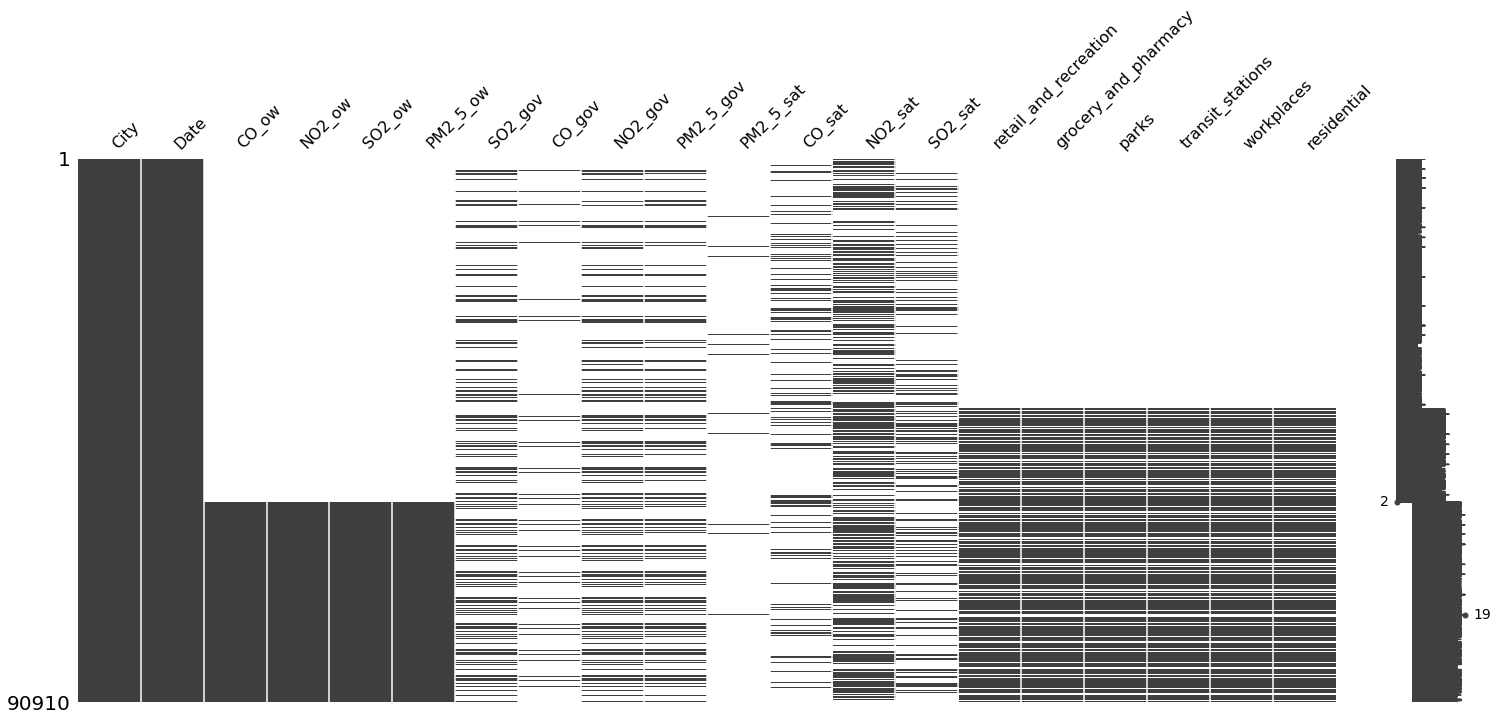

In [28]:
fig = msno.matrix(all_data)
fig_copy = fig.get_figure()
fig_copy.savefig(".\\Plotting\\paper figures\\missingness.jpg", dpi=200, bbox_inches = 'tight')

In [7]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False).fit(all_data["City"].values.reshape(-1, 1))
ohe = pd.DataFrame(enc.transform(all_data["City"].values.reshape(-1, 1)))
all_data_ohe = pd.concat([ohe, all_data.drop(columns="City")], axis=1, ignore_index=False)

In [8]:
def find_optimal_imputation_k(X, y):
    all_scores = []
    potential_ks = [1, 2, 4, 8]
    for k in potential_ks:
        knn = KNeighborsRegressor(n_neighbors=k, weights="distance")
        scores = cross_val_score(knn, X, y, cv=5, scoring="neg_mean_absolute_error")
        all_scores.append(np.mean(scores))
        
    print("Imputation:", potential_ks[np.argmax(all_scores)], max(all_scores))
    return potential_ks[np.argmax(all_scores)]

In [9]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

SO2_gov
Imputation: 8 -4.461913447409264


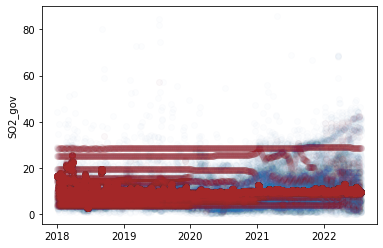

CO_gov
Imputation: 8 -324.5565785758113


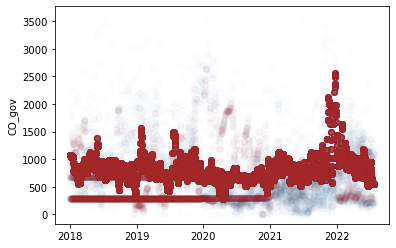

NO2_gov
Imputation: 8 -12.890456473652572


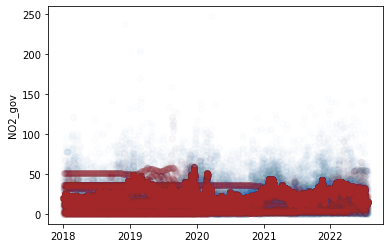

PM2_5_gov
Imputation: 8 -23.971007397153073


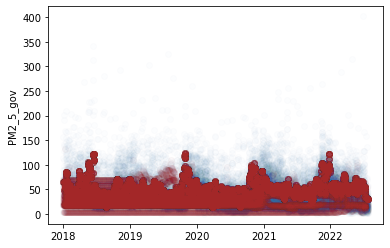

PM2_5_sat
Imputation: 1 -76.51410658593224


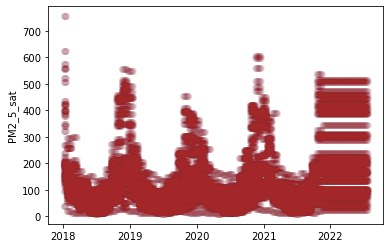

CO_sat
Imputation: 8 -116.24547914391628


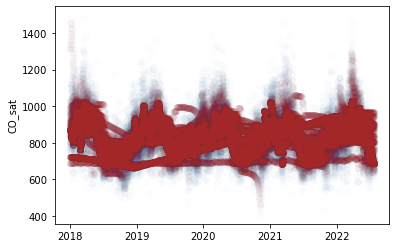

NO2_sat
Imputation: 8 -5.341247121764637


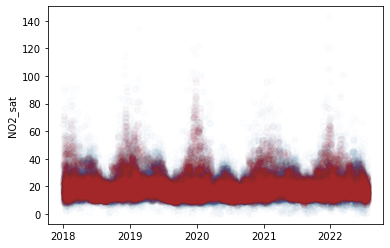

SO2_sat
Imputation: 8 -13.065784747054357


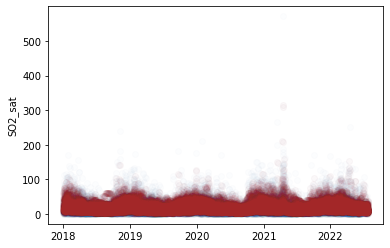

retail_and_recreation
Imputation: 1 -15.69117440718395


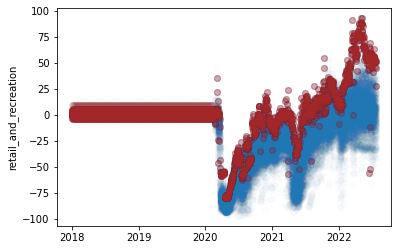

grocery_and_pharmacy
Imputation: 1 -18.29106728867785


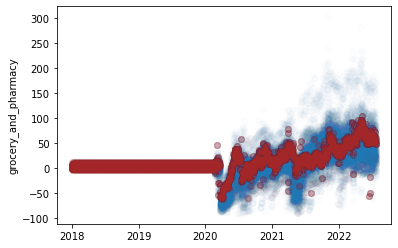

parks
Imputation: 2 -19.207313738819842


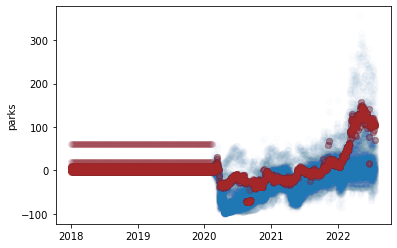

transit_stations
Imputation: 1 -19.404767914738464


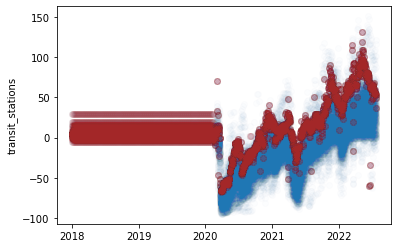

workplaces
Imputation: 8 -15.510717040729412


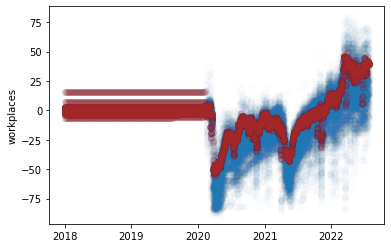

residential
Imputation: 4 -5.185116242956559


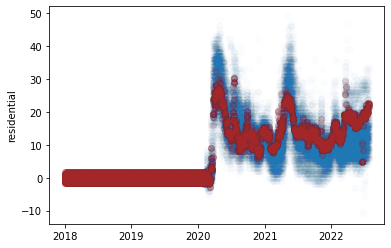

In [10]:
all_data_imputed = all_data.copy()

for col in all_data:
    if col in ["Date", "City", "SO2_ow", "CO_ow", "NO2_ow", "PM2_5_ow"]:
        continue
    print(col)
    na_inds = np.where(all_data[col].isna() == True)[0]
    na_dates = all_data_imputed["Date"].iloc[na_inds]
    na_timestamps = [calendar.timegm(i.timetuple()) for i in na_dates]


    cols = [i for i in range(len(city_list))]
    cols.append("Date")
    cols.append(col)
    
    sub_df = all_data_ohe[cols].dropna().reset_index(drop=True)
    sub_df["Date"] = [calendar.timegm(i.timetuple()) for i in sub_df["Date"]]

    X = sub_df.drop(columns=col)
    y = sub_df[col]
    
    scaler = StandardScaler()
    scaled_X = scaler.fit_transform(X)
#     scaled_X = X.copy()
#     print(X.shape, y.shape)

    optimal_k = find_optimal_imputation_k(scaled_X, y)
    knn = KNeighborsRegressor(n_neighbors=optimal_k, weights="distance")
    knn.fit(scaled_X, y)
    
    missing_data = all_data_ohe[cols].iloc[na_inds].reset_index(drop=True)
    missing_data["Date"] = na_timestamps
    test_X = missing_data.drop(columns=col)
    scaled_test_X = scaler.transform(test_X)#.reshape(-1, 55)
    
    preds = knn.predict(scaled_test_X)

    all_data_imputed.loc[na_inds, col] = preds.flatten()
    
    plt.plot_date(all_data_imputed["Date"], all_data_imputed[col], alpha=0.01)
    plt.plot_date(all_data_imputed["Date"].values[na_inds], all_data_imputed[col].values[na_inds], alpha=0.02, c="tab:red")
    plt.ylabel(col)
    plt.show()

SO2_gov
Imputation: 2 -5.595231506663873


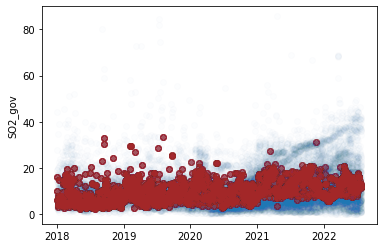

CO_gov
Imputation: 2 -375.50823249115126


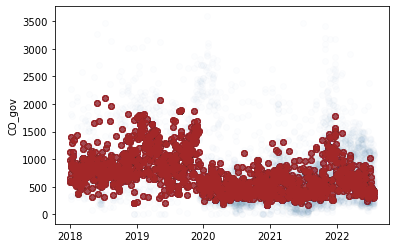

NO2_gov
Imputation: 2 -14.53919530185378


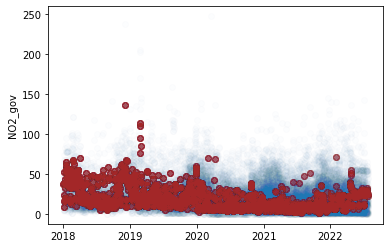

PM2_5_gov
Imputation: 4 -25.156056228930446


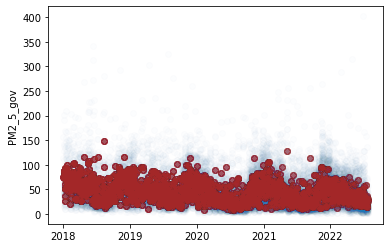

PM2_5_sat
Imputation: 8 -68.6919969046836


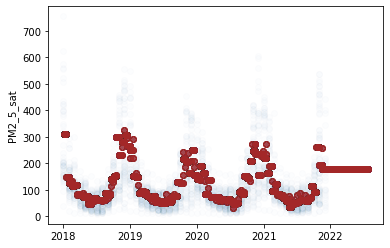

CO_sat
Imputation: 8 -118.1920560755701


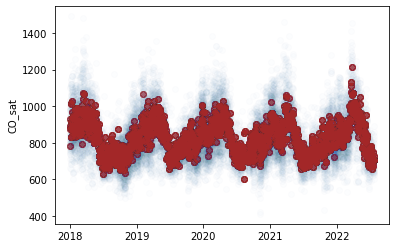

NO2_sat
Imputation: 2 -6.790767966887984


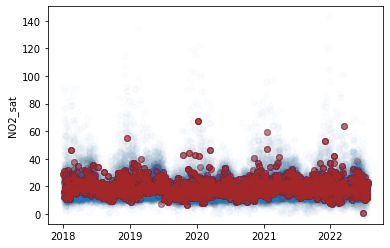

SO2_sat
Imputation: 8 -14.040566616498557


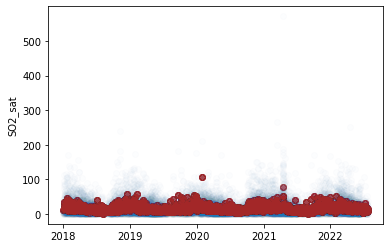

retail_and_recreation
Imputation: 1 -17.50009821804406


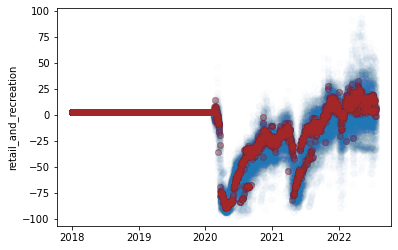

grocery_and_pharmacy
Imputation: 4 -26.116733753032207


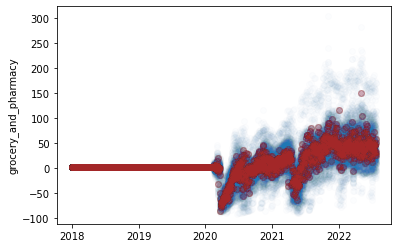

parks
Imputation: 8 -25.99033701088525


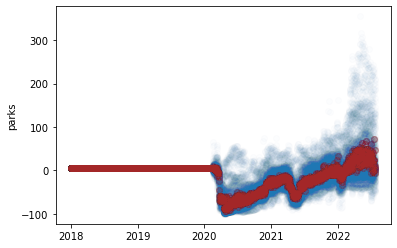

transit_stations
Imputation: 4 -22.160180900294485


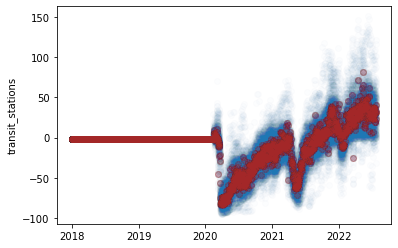

workplaces
Imputation: 8 -16.176226177130047


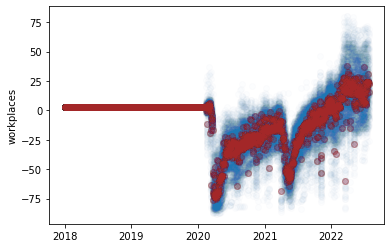

residential
Imputation: 8 -5.753468329596412


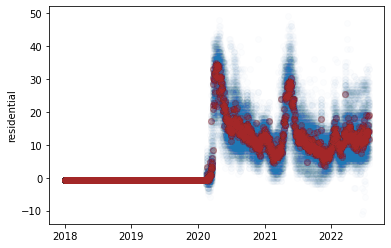

In [11]:
all_data_imputed = all_data.copy()

for col in all_data:
    if col in ["Date", "City", "SO2_ow", "CO_ow", "NO2_ow", "PM2_5_ow"]:
        continue
    print(col)
    na_inds = np.where(all_data[col].isna() == True)[0]
    na_dates = all_data_imputed["Date"].iloc[na_inds]
    na_timestamps = [calendar.timegm(i.timetuple()) for i in na_dates]


    cols = [i for i in range(len(city_list))]
    cols.append("Date")
    cols.append(col)
    
    sub_df = all_data_ohe[cols].dropna().reset_index(drop=True)
    sub_df["Date"] = [calendar.timegm(i.timetuple()) for i in sub_df["Date"]]

    X = sub_df.drop(columns=col)
    y = sub_df[col]
    
#     scaler = StandardScaler()
#     scaled_X = scaler.fit_transform(X)
    scaled_X = X.copy()
#     print(X.shape, y.shape)

    optimal_k = find_optimal_imputation_k(scaled_X, y)
    knn = KNeighborsRegressor(n_neighbors=optimal_k, weights="distance")
    knn.fit(scaled_X, y)
    
    missing_data = all_data_ohe[cols].iloc[na_inds].reset_index(drop=True)
    missing_data["Date"] = na_timestamps
    test_X = missing_data.drop(columns=col)
#     scaled_test_X = scaler.transform(test_X)#.reshape(-1, 55)
    scaled_test_X = test_X.copy()
    preds = knn.predict(scaled_test_X)

    all_data_imputed.loc[na_inds, col] = preds.flatten()
    
    plt.plot_date(all_data_imputed["Date"], all_data_imputed[col], alpha=0.01)
    plt.plot_date(all_data_imputed["Date"].values[na_inds], all_data_imputed[col].values[na_inds], alpha=0.02, c="tab:red")
    plt.ylabel(col)
    plt.show()

Imputation: 8 -118.1920560755701
Imputation: 8 -116.24547914391628


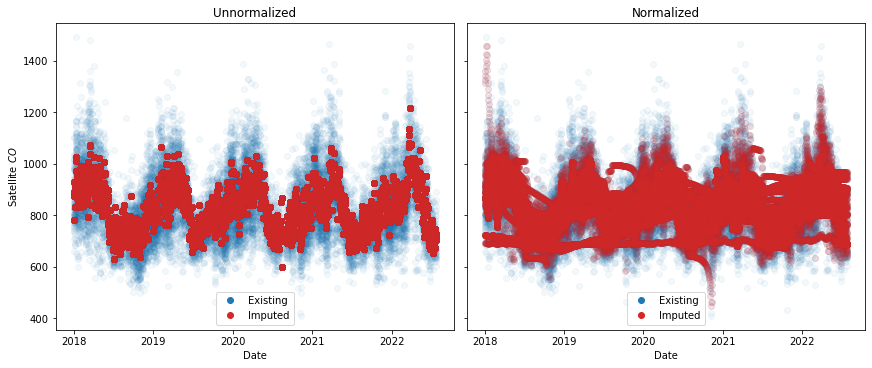

In [21]:
col = "CO_sat"
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12, 5), layout="constrained", sharey=True)







all_data_imputed = all_data.copy()

na_inds = np.where(all_data[col].isna() == True)[0]
na_dates = all_data_imputed["Date"].iloc[na_inds]
na_timestamps = [calendar.timegm(i.timetuple()) for i in na_dates]


cols = [i for i in range(len(city_list))]
cols.append("Date")
cols.append(col)

sub_df = all_data_ohe[cols].dropna().reset_index(drop=True)
sub_df["Date"] = [calendar.timegm(i.timetuple()) for i in sub_df["Date"]]

X = sub_df.drop(columns=col)
y = sub_df[col]

#     scaler = StandardScaler()
#     scaled_X = scaler.fit_transform(X)
scaled_X = X.copy()
#     print(X.shape, y.shape)

optimal_k = find_optimal_imputation_k(scaled_X, y)
knn = KNeighborsRegressor(n_neighbors=optimal_k, weights="distance")
knn.fit(scaled_X, y)

missing_data = all_data_ohe[cols].iloc[na_inds].reset_index(drop=True)
missing_data["Date"] = na_timestamps
test_X = missing_data.drop(columns=col)
#     scaled_test_X = scaler.transform(test_X)#.reshape(-1, 55)
scaled_test_X = test_X.copy()
preds = knn.predict(scaled_test_X)

all_data_imputed.loc[na_inds, col] = preds.flatten()






axs[0].plot_date(all_data_imputed["Date"], all_data_imputed[col], alpha=0.05, label="Existing")
axs[0].plot_date(all_data_imputed["Date"].values[na_inds], all_data_imputed[col].values[na_inds], alpha=0.1, c="tab:red", label="Imputed")
axs[0].set_ylabel("Satellite $CO$")
axs[0].set_xlabel("Date")
axs[0].set_title("Unnormalized")
leg = axs[0].legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)










all_data_imputed = all_data.copy()

na_inds = np.where(all_data[col].isna() == True)[0]
na_dates = all_data_imputed["Date"].iloc[na_inds]
na_timestamps = [calendar.timegm(i.timetuple()) for i in na_dates]


cols = [i for i in range(len(city_list))]
cols.append("Date")
cols.append(col)

sub_df = all_data_ohe[cols].dropna().reset_index(drop=True)
sub_df["Date"] = [calendar.timegm(i.timetuple()) for i in sub_df["Date"]]

X = sub_df.drop(columns=col)
y = sub_df[col]

scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)
#     scaled_X = X.copy()
#     print(X.shape, y.shape)

optimal_k = find_optimal_imputation_k(scaled_X, y)
knn = KNeighborsRegressor(n_neighbors=optimal_k, weights="distance")
knn.fit(scaled_X, y)

missing_data = all_data_ohe[cols].iloc[na_inds].reset_index(drop=True)
missing_data["Date"] = na_timestamps
test_X = missing_data.drop(columns=col)
scaled_test_X = scaler.transform(test_X)#.reshape(-1, 55)

preds = knn.predict(scaled_test_X)

all_data_imputed.loc[na_inds, col] = preds.flatten()











axs[1].plot_date(all_data_imputed["Date"], all_data_imputed[col], alpha=0.05, label="Existing")
axs[1].plot_date(all_data_imputed["Date"].values[na_inds], all_data_imputed[col].values[na_inds], alpha=0.1, c="tab:red", label="Imputed")
axs[1].set_xlabel("Date")
axs[1].set_title("Normalized")
leg = axs[1].legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)

fig.savefig(".\\Plotting\\paper figures\\missing_data.jpg", dpi=200)


In [12]:
traffic_start_date = min(all_data.dropna(subset="retail_and_recreation")["Date"])

all_data_imputed.loc[all_data_imputed["Date"]<traffic_start_date, "retail_and_recreation"] = 0
all_data_imputed.loc[all_data_imputed["Date"]<traffic_start_date, "grocery_and_pharmacy"] = 0
all_data_imputed.loc[all_data_imputed["Date"]<traffic_start_date, "parks"] = 0
all_data_imputed.loc[all_data_imputed["Date"]<traffic_start_date, "transit_stations"] = 0
all_data_imputed.loc[all_data_imputed["Date"]<traffic_start_date, "workplaces"] = 0
all_data_imputed.loc[all_data_imputed["Date"]<traffic_start_date, "residential"] = 0

In [13]:
traffic_start_date = min(all_data.dropna(subset="retail_and_recreation")["Date"])
traffic_start_date

Timestamp('2020-02-15 00:00:00')

In [14]:
# all_data_imputed.to_csv(".\\data\\processed_new\\all_data_imputed.csv", index=False)